In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam  #설정해줘야함
from keras.models import load_model

In [5]:
cd /content/drive/Othercomputers/내 노트북/07_PJT_final_01/01_clothes_classification

/content/drive/Othercomputers/내 노트북/07_PJT_final_01/01_clothes_classification


In [6]:
img_size = 64
channel=3

In [7]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        # rotation_range=40,      # 40도까지 회전
        # width_shift_range=0.2,  # 20%까지 좌우 이동
        # height_shift_range=0.2, # 20%까지 상하 이동
        # shear_range=0.2,        # 20%까지 기울임
        # zoom_range=0.2,         # 20%까지 확대
        # horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/Train',
    batch_size=100,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/Validation',
    batch_size=40,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/data/test',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 14341 images belonging to 4 classes.
Found 7894 images belonging to 4 classes.
Found 10 images belonging to 4 classes.


#  ResNet50 
- imagenet 전이학습
- 은닉층
    * Flatten()
- 출력층
    * Dense(4, activation='softmax')

In [ ]:
resnet50 = tf.keras.applications.ResNet50(weights='imagenet',
                                          include_top=False,
                                          input_shape=(img_size, img_size, 3))
resnet50.trainable = False

In [ ]:
model = Sequential()
model.add(resnet50)
model.add(Flatten())
model.add(Dense(4, activation='softmax')) # 다중분류 4개로 변경
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 23,620,484
Trainable params: 32,772
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# 모델 환경설정
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model_name = './model/resnet50_01_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=5) # 5번동안 성능개선이 없으면 학습 조기종료

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=valid_generator,
                    callbacks = [[earlystopping, checkpointer]]) 

Epoch 1/100
325/325 [==============================] - 11980s 37s/step - loss: 0.8522 - accuracy: 0.6867 - val_loss: 0.7477 - val_accuracy: 0.7104
Epoch 2/100
325/325 [==============================] - 760s 2s/step - loss: 0.7328 - accuracy: 0.7273 - val_loss: 0.6960 - val_accuracy: 0.7245
Epoch 3/100
325/325 [==============================] - 759s 2s/step - loss: 0.6967 - accuracy: 0.7403 - val_loss: 0.6632 - val_accuracy: 0.7384
Epoch 4/100
325/325 [==============================] - 760s 2s/step - loss: 0.6751 - accuracy: 0.7474 - val_loss: 0.6468 - val_accuracy: 0.7463
Epoch 5/100
325/325 [==============================] - 762s 2s/step - loss: 0.6568 - accuracy: 0.7532 - val_loss: 0.6177 - val_accuracy: 0.7592
Epoch 6/100
325/325 [==============================] - 761s 2s/step - loss: 0.6438 - accuracy: 0.7585 - val_loss: 0.6065 - val_accuracy: 0.7620
Epoch 7/100
325/325 [==============================] - 762s 2s/step - loss: 0.6329 - accuracy: 0.7625 - val_loss: 0.5932 - val_accura

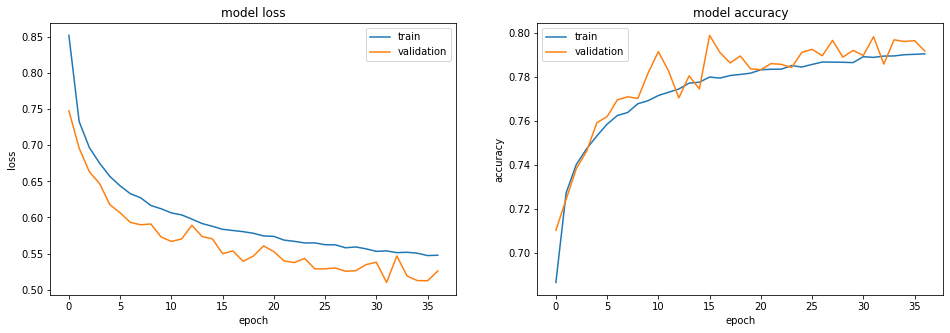

In [ ]:
# 모델 학습 과정 시각화
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [ ]:
model.save('./model/ResNet_1.h5')

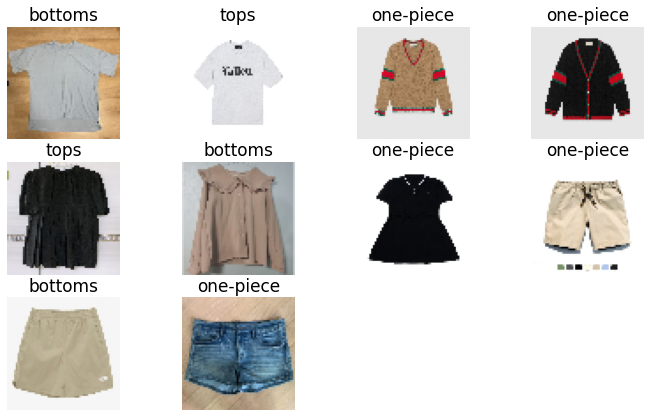

In [21]:
# 구글에서 가져온 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(64,64))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()

# 모델 이어서 학습하기

In [10]:
# 모델 가져오기
model = load_model('./model/ResNet_1.h5')

In [22]:
model_name = './model/resnet50_02_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=5) # 5번동안 성능개선이 없으면 학습 조기종료

In [23]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=valid_generator,
                    callbacks = [[earlystopping, checkpointer]]) 

Epoch 1/100
325/325 [==============================] - 21426s 66s/step - loss: 0.5474 - accuracy: 0.7910 - val_loss: 0.5123 - val_accuracy: 0.8066
Epoch 2/100
325/325 [==============================] - 728s 2s/step - loss: 0.5456 - accuracy: 0.7912 - val_loss: 0.5107 - val_accuracy: 0.7974
Epoch 3/100
325/325 [==============================] - 730s 2s/step - loss: 0.5448 - accuracy: 0.7918 - val_loss: 0.5357 - val_accuracy: 0.7892
Epoch 4/100
325/325 [==============================] - 729s 2s/step - loss: 0.5410 - accuracy: 0.7923 - val_loss: 0.5349 - val_accuracy: 0.7928
Epoch 5/100
325/325 [==============================] - 729s 2s/step - loss: 0.5419 - accuracy: 0.7923 - val_loss: 0.5130 - val_accuracy: 0.7990
Epoch 6/100
325/325 [==============================] - 730s 2s/step - loss: 0.5407 - accuracy: 0.7938 - val_loss: 0.5271 - val_accuracy: 0.7921
Epoch 7/100
325/325 [==============================] - 732s 2s/step - loss: 0.5389 - accuracy: 0.7935 - val_loss: 0.5332 - val_accura

In [ ]:
# 구글에서 가져온 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(64,64))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()